# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from time import perf_counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# from google.colab import drive
# drive.mount('/gdrive')

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '-1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 


pd.set_option('display.max_rows', 9999)
pd.set_option('display.max_columns', 999)

%matplotlib inline

# Data

In [3]:
X_station = pd.read_csv("X_station_day.csv")

X_station['precipitations_sqrt'] = np.sqrt(X_station['precipitations'])
X_station['ground_truth_bool'] = np.uint8(X_station['ground_truth'] > 0)

print(round(X_station['precipitations'].max(), 1))
print(round(X_station['precipitations_sqrt'].max(), 1))

X_station

75.8
8.7


,station_id,year,month,day,latitude,longitude,altitude,wind_direction,wind_speed,temperature,humidity,dew_point,precipitations,ground_truth,precipitations_sqrt,ground_truth_bool
0,14066001,2016,1,1,49.334,-0.431,2,146.50000,3.913750,280.33374,88.591670,278.51460,0.2,3.4,0.447214,1
1,14066001,2016,1,2,49.334,-0.431,2,205.62500,8.041250,282.93668,82.300000,279.99750,3.4,11.7,1.843909,1
2,14066001,2016,1,3,49.334,-0.431,2,195.25000,5.430417,281.10165,86.604164,278.99750,11.7,0.6,3.420526,1
3,14066001,2016,1,4,49.334,-0.431,2,212.66667,6.715417,281.05500,80.645836,277.90082,0.6,0.4,0.774597,1
4,14066001,2016,1,5,49.334,-0.431,2,205.04167,5.957083,281.25583,82.750000,278.48416,0.4,3.0,0.632456,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82115,95690001,2017,12,26,49.108,1.831,126,202.33333,7.699167,279.04166,85.587500,276.80000,2.4,3.2,1.549193,1
82116,95690001,2017,12,27,49.108,1.831,126,251.50000,8.134167,277.27457,86.275000,275.16043,3.2,0.0,1.788854,0
82117,95690001,2017,12,28,49.108,1.831,126,253.58333,3.172500,275.01960,86.816666,273.01460,0.0,4.4,0.000000,1
82118,95690001,2017,12,29,49.108,1.831,126,211.50000,6.341250,277.45250,86.637500,275.34125,4.4,5.4,2.097618,1


In [4]:
X_train = X_station[['month', 'latitude', 'longitude', 'altitude', 'wind_direction', 'wind_speed', 'temperature', 'humidity', 'dew_point', 'precipitations', 'ground_truth', 'precipitations_sqrt', 'ground_truth_bool']]
X_train = X_train.astype('float32')


min_factor = X_train.min(axis=0)
max_factor = X_train.max(axis=0)

def normalization(X):
    return (X - min_factor) / (max_factor - min_factor)

def de_normalization(X):
    return (X * (max_factor - min_factor)) + min_factor

def precip_denormalization(X_precip):
    return (X_precip * (max_factor[9] - min_factor[9])) + min_factor[9]


X_train = normalization(X_train)

X_train

,month,latitude,longitude,altitude,wind_direction,wind_speed,temperature,humidity,dew_point,precipitations,ground_truth,precipitations_sqrt,ground_truth_bool
0,0.0,0.649871,0.656219,0.000000,0.413598,0.183694,0.356908,0.845424,0.490528,0.002639,0.044855,0.051367,1.0
1,0.0,0.649871,0.656219,0.000000,0.580520,0.377420,0.426399,0.760176,0.525736,0.044855,0.154354,0.211790,1.0
2,0.0,0.649871,0.656219,0.000000,0.551229,0.254879,0.377409,0.818495,0.501994,0.154354,0.007916,0.392879,1.0
3,0.0,0.649871,0.656219,0.000000,0.600400,0.315191,0.376164,0.737763,0.475956,0.007916,0.005277,0.088969,1.0
4,0.0,0.649871,0.656219,0.000000,0.578873,0.279599,0.381525,0.766273,0.489806,0.005277,0.039578,0.072643,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
82115,1.0,0.601206,0.977024,0.407895,0.571227,0.361364,0.322413,0.804720,0.449819,0.031662,0.042216,0.177939,1.0
82116,1.0,0.601206,0.977024,0.407895,0.710034,0.381781,0.275237,0.814035,0.410892,0.042216,0.000000,0.205466,0.0
82117,1.0,0.601206,0.977024,0.407895,0.715916,0.148903,0.215035,0.821374,0.359945,0.000000,0.058047,0.000000,1.0
82118,1.0,0.601206,0.977024,0.407895,0.597106,0.297630,0.279988,0.818946,0.415185,0.058047,0.071240,0.240930,1.0


In [17]:
def correlation_matrix(df):
    X_train = df.copy().astype('float32')

    min_factor = X_train.min(axis=0)
    max_factor = X_train.max(axis=0)

    X_train = (X_train - min_factor) / (max_factor - min_factor)

    corr_mat = X_train.corr()

    plt.figure(figsize=(7,7), dpi=100)

    plt.imshow(corr_mat, vmin=-1, vmax=1, cmap='bwr')

    for (j,i),label in np.ndenumerate(corr_mat):
        plt.text(i,j, f"{label:.2f}", ha='center',va='center', color='k', fontsize=10, alpha=0.8)

    plt.colorbar(fraction=0.045, pad=0.04)
    plt.title("Correlation Matrix", fontsize=17)
    plt.yticks(range(len(X_train.columns)), X_train.columns)
    plt.xticks(range(len(X_train.columns)), X_train.columns, rotation=70)

    plt.show()

(82120, 10)
(74120, 10) (74120,)
(8000, 10) (8000,)


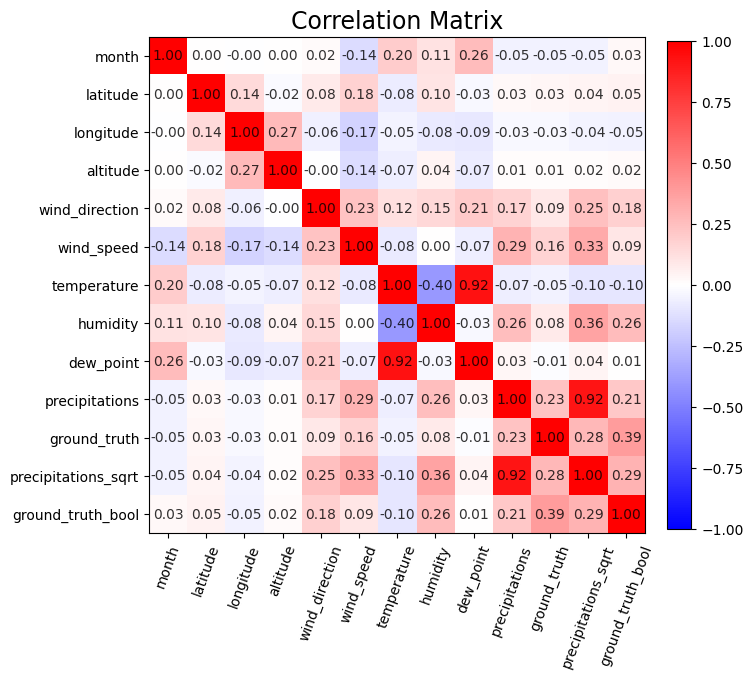

In [9]:
L_labels = ['precipitations', 'month', 'latitude', 'longitude', 'altitude', 'wind_direction', 'wind_speed', 'temperature', 'humidity', 'dew_point']
np_X_train = np.float32(X_train[L_labels])
np_Y_train = np.uint8(X_station['precipitations'])
print(np_X_train.shape)

np.random.seed(123)
idx = np.arange(np_X_train.shape[0])
np.random.shuffle(idx)

# Validation set
np_X_val = np_X_train[idx[:8_000]]
np_Y_val = np_Y_train[idx[:8_000]]

# Training set
np_X_train = np_X_train[idx[8_000:]]
np_Y_train = np_Y_train[idx[8_000:]]

print(np_X_train.shape, np_Y_train.shape)
print(np_X_val.shape, np_Y_val.shape)


correlation_matrix(X_train)

# VAE Architecture

In [16]:
class Sampling(layers.Layer):
    """Sampling layer - Gaussian distribution"""

    def call(self, inputs):
        z_mean, z_std = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_std) * epsilon



def create_encoder(L_neurons, SUMMARY=False):
    inputs = keras.Input(shape=(L_neurons[0]))

    x = inputs
    for n in L_neurons[1:-1]:
        x = layers.Dense(n, activation="relu")(x)

    z_mean = layers.Dense(L_neurons[-1], name="z_mean")(x)
    z_std = layers.Dense(L_neurons[-1], name="z_std")(x)
    z = Sampling()([z_mean, z_std])

    encoder = keras.Model(inputs, [z_mean, z_std, z], name="encoder")

    if SUMMARY:
        encoder.summary()

    return encoder


def create_decoder(L_neurons, SUMMARY=False):
    inputs = keras.Input(shape=(L_neurons[0],))

    x = inputs
    for n in L_neurons[1:-1]:
        x = layers.Dense(n, activation="relu")(x)

    x = layers.Dense(L_neurons[-1], activation="sigmoid")(x)
    
    decoder = keras.Model(inputs, x, name="decoder")

    if SUMMARY:
        decoder.summary()

    return decoder



class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.mse_loss_tracker = keras.metrics.Mean(name="mse_loss")
        self.kl_divergence_tracker = keras.metrics.Mean(name="kl_divergence")
        
        self.val_total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.val_mse_loss_tracker = keras.metrics.Mean(name="mse_loss")
        self.val_kl_divergence_tracker = keras.metrics.Mean(name="kl_divergence")


    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.mse_loss_tracker,
                self.kl_divergence_tracker,
                self.val_total_loss_tracker,
                self.val_mse_loss_tracker,
                self.val_kl_divergence_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_std, z = self.encoder(data)
            reconstruction = self.decoder(z)

            mse_loss = tf.keras.losses.MeanSquaredError()(data, reconstruction)
            kl_div = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + z_std - tf.square(z_mean) - tf.exp(z_std)), axis=1))
            total_loss = mse_loss + kl_div

        
        grads = tape.gradient(total_loss, self.trainable_weights)
        
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.mse_loss_tracker.update_state(mse_loss)
        self.kl_divergence_tracker.update_state(kl_div)

        return {"loss": self.total_loss_tracker.result(),
                "mse_loss": self.mse_loss_tracker.result(),
                "kl_divergence": self.kl_divergence_tracker.result()}


    def call(self, data):
        z_mean, z_std, z = self.encoder(data)
        reconstruction = self.decoder(z)

        mse_loss = tf.keras.losses.MeanSquaredError()(data, reconstruction)
        kl_div = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + z_std - tf.square(z_mean) - tf.exp(z_std)), axis=1))
        total_loss = mse_loss + kl_div

        self.val_total_loss_tracker.update_state(total_loss)
        self.val_mse_loss_tracker.update_state(mse_loss)
        self.val_kl_divergence_tracker.update_state(kl_div)

        return {"val_loss": self.val_total_loss_tracker.result(),
                "mse_loss": self.val_mse_loss_tracker.result(),
                "kl_divergence": self.val_kl_divergence_tracker.result()}



# Training

In [25]:
def compute_param (model):
    return np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])



def fit_vae(n, latent_dim, N_EPOCH=100):
    
    encoder = create_encoder([10, n, latent_dim])  # Input_dim, neurons, latent_dim
    decoder = create_decoder([latent_dim, n, 10])  # latent_dim, neurons, Input_dim

    vae_model = VAE(encoder, decoder)
    vae_model.compile(optimizer=keras.optimizers.Adam(0.0001))

    params = compute_param(vae_model)

    L_loss = []
    L_mse = []
    L_KLDiv = []
    L_val_loss = []
    L_val_mse = []
    L_val_KLDiv = []


    T0 = perf_counter()

    history = vae_model.fit(np_X_train, epochs=N_EPOCH, batch_size=128, validation_data=(np_X_val,np_X_val), verbose=0)

    T1 = perf_counter()

    L_loss    += list(history.history['loss'])
    L_mse     += list(history.history['mse_loss'])
    L_KLDiv   += list(history.history['kl_divergence'])
    L_val_loss    += list(history.history['val_total_loss'])
    L_val_mse     += list(history.history['val_mse_loss'])
    L_val_KLDiv   += list(history.history['val_kl_divergence'])

    print(f"MSE = {L_mse[-1]:.9f}")
    print(f"KL Div = {L_KLDiv[-1]:.9f}")
    print(f"Val MSE = {L_val_mse[-1]:.9f}")
    print(f"Val KL Div = {L_val_KLDiv[-1]:.9f}")
    print(f"Time : {T1-T0:.1f} sec")
    # print()
    
    del(encoder)
    del(decoder)
    del(vae_model)

    return L_mse, L_val_mse, L_KLDiv, L_val_KLDiv, T1-T0, params



def FIT(latent_dim):
    d_metrics = {'MSE_train':[], 'MSE_val':[], 'KLdiv_train':[], 'KLdiv_val':[], 'time':[], 'params':[]}

    T0 = perf_counter()

    for n in L_neurons:
        print("========================================")
        print(n)

        MSE_train, MSE_val, KLdiv_train, KLdiv_val, time, params = fit_vae(n, latent_dim)

        d_metrics['MSE_train'] += MSE_train
        d_metrics['MSE_val'] += MSE_val
        d_metrics['KLdiv_train'] += KLdiv_train
        d_metrics['KLdiv_val'] += KLdiv_val
        d_metrics['time'] += time
        d_metrics['params'] += params

    T1 = perf_counter()

    print("\n##############################################\n")
    print(f"\nTotal Time : {T1-T0:.1f} sec")

    return d_metrics





def plot_projection(d_metrics, mode='reconstruction'):
    N = len(d_metrics['MSE_train'])

    plt.figure(figsize=(40, 30), dpi=150)

    for i in range(10):
        plt.subplot(N+1,10,i+1)
        plt.title(L_labels[i], fontsize=16)
        plt.scatter(np_X_val[:, i], np_X_val[:, 0], c=precip_denormalization(np_X_val[:, 0]), alpha=0.5, s=10)
        plt.colorbar(); plt.xlim(0,1); plt.ylim(0,1)

        if i == 0:
            plt.ylabel("Original Distribution", fontsize=16)

        for k in range(N):
            plt.subplot(N+1,10, (k+1)*10+i+1)
            plt.scatter(d_metrics[mode][k][:, i], d_metrics[mode][k][:, 0], c=precip_denormalization(d_metrics[mode][k][:, 0]), alpha=0.5, s=10)
            plt.colorbar(); #plt.xlim(0,1); plt.ylim(0,1)

            if i == 0:
                plt.ylabel(L_neurons[k], fontsize=16)

    plt.show()






def plot_curves(d_metrics):
    N = len(d_metrics['MSE_train'])
    m = 30

    plt.figure(figsize=(30, 6), dpi=150)

    plt.subplot(141)
    plt.title("MSE (Train)")
    for k in range(N):
        plt.plot(d_metrics['MSE_train'][k][m:])
    plt.xlabel('epoch')
    plt.legend(L_neurons)
    plt.grid(True)
#     plt.ylim(0, 0.025)

    plt.subplot(142)
    plt.title("MSE (Validation)")
    for k in range(N):
        plt.plot(d_metrics['MSE_val'][k][m:], '--')
    plt.xlabel('epoch')
    plt.legend(L_neurons)
    plt.grid(True)
#     plt.ylim(0, 0.025)

    plt.subplot(143)
    plt.title("KL Divergence (Train)")
    for k in range(N):
        plt.plot(d_metrics['KLdiv_train'][k][m:])
    plt.xlabel('epoch')
    plt.legend(L_neurons)
    plt.grid(True)
#     plt.ylim(0, 0.5)

    plt.subplot(144)
    plt.title("KL Divergence (Validation)")
    for k in range(N):
        plt.plot(d_metrics['KLdiv_val'][k][m:], '--')
    plt.xlabel('epoch')
    plt.legend(L_neurons)
    plt.grid(True)
#     plt.ylim(0, 0.5)

    plt.show()


def plot_ALL(d_metrics):
    
    N = len(d_metrics['MSE_train'])

    for k in range(N):
        print(f"{d_metrics['MSE_train'][k][-1]:.9f}, {d_metrics['MSE_val'][k][-1]:.9f}, {d_metrics['KLdiv_train'][k][-1]:.9f}, {d_metrics['KLdiv_val'][k][-1]:.9f}, {d_metrics['time'][k]:.2f}, {d_metrics['params'][k]:.0f}")

    plot_projection(d_metrics, 'reconstruction')
    plot_projection(d_metrics, 'sampling')

    plot_curves(d_metrics)


L_neurons = [4, 8, 16, 32, 64, 128]

In [ ]:
d_metrics_2 = FIT(latent_dim=2)

plot_ALL(d_metrics_2)

In [ ]:
d_metrics_5 = FIT(latent_dim=5)

plot_ALL(d_metrics_5)

In [ ]:
d_metrics_10 = FIT(latent_dim=10)

plot_ALL(d_metrics_10)

In [ ]:
d_metrics_15 = FIT(latent_dim=15)

plot_ALL(d_metrics_15)

In [27]:
import pickle
pickle.dump(d_metrics_2, open("./d_metrics_2.pickle", "wb"))
pickle.dump(d_metrics_5, open("./d_metrics_5.pickle", "wb"))
pickle.dump(d_metrics_10, open("./d_metrics_10.pickle", "wb"))
pickle.dump(d_metrics_15, open("./d_metrics_15.pickle", "wb"))

# Training plots

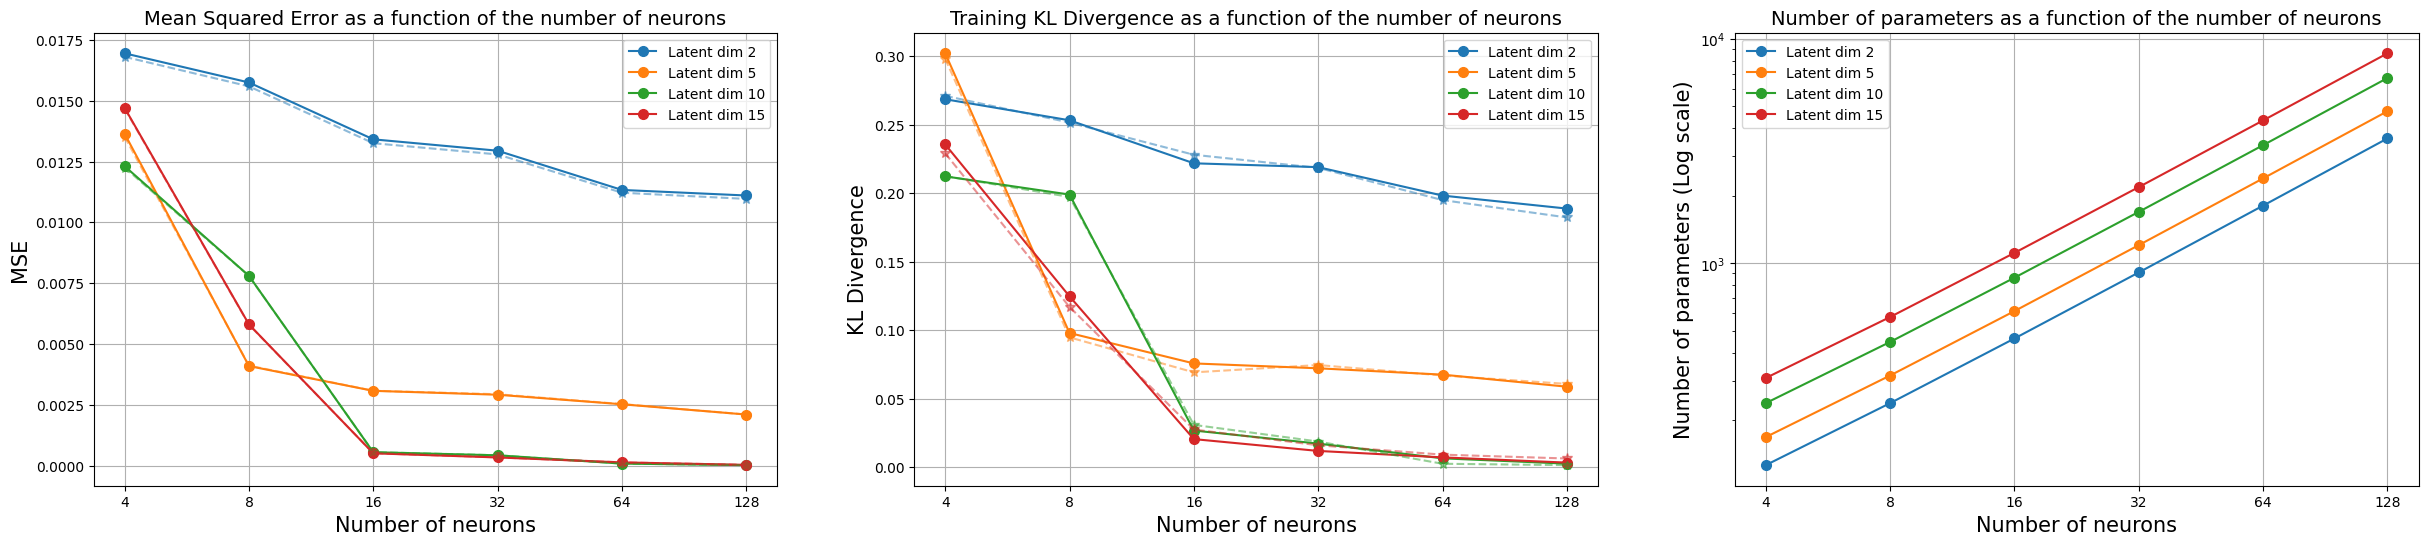

In [27]:
######################################################
# Training loss : MSE
######################################################



L_neurons = [4, 8, 16, 32, 64, 128]
L_labels = ['MSE_train', 'MSE_val', 'KLdiv_train', 'KLdiv_val', 'time', 'params']

LatentDim_2 = np.array([[0.016944817, 0.016801012, 0.268434450, 0.270911425, 30.40, 126],
                        [0.015746463, 0.015587216, 0.253081303, 0.251420017, 29.95, 238],
                        [0.013410631, 0.013251846, 0.221720330, 0.227943331, 30.15, 462],
                        [0.012943764, 0.012790524, 0.218925841, 0.218389787, 31.28, 910],
                        [0.011331921, 0.011217474, 0.198185205, 0.194898747, 36.11, 1806],
                        [0.011103541, 0.010963236, 0.188711479, 0.182237469, 40.88, 3598]])


LatentDim_5 = np.array([[0.013639953, 0.013516098, 0.301922895, 0.297964379, 30.85, 168],
                        [0.004096834, 0.004114746, 0.097971652, 0.094805058, 31.43, 316],
                        [0.003078073, 0.003083038, 0.075790491, 0.069278408, 32.56, 612],
                        [0.002918366, 0.002938959, 0.072237946, 0.074624017, 33.33, 1204],
                        [0.002527003, 0.002534972, 0.067616943, 0.066995081, 37.91, 2388],
                        [0.002104309, 0.002105658, 0.058827093, 0.060863739, 42.56, 4756]])


LatentDim_10 = np.array([[0.012308697, 0.012251507, 0.212198757, 0.212372310, 33.35, 238],
                        [0.007803403, 0.007797960, 0.198907917, 0.197210038, 33.30, 446],
                        [0.000557242, 0.000560417, 0.026863953, 0.030981654, 33.34, 862],
                        [0.000429600, 0.000431864, 0.017316345, 0.018826831, 34.53, 1694],
                        [0.000088720, 0.000088865, 0.006590362, 0.002625669, 38.98, 3358],
                        [0.000026296, 0.000025985, 0.002702713, 0.001627915, 43.03, 6686]])


LatentDim_15 = np.array([[0.014703420, 0.014677492, 0.235494465, 0.228992611, 35.04, 308],
                        [0.005808383, 0.005796451, 0.124688257, 0.116968036, 35.49, 576],
                        [0.000511726, 0.000515915, 0.020605478, 0.027623991, 34.92, 1112],
                        [0.000341742, 0.000345451, 0.011982974, 0.016085308, 37.36, 2184],
                        [0.000138442, 0.000139534, 0.007279621, 0.009277337, 43.13, 4328],
                        [0.000036417, 0.000036757, 0.003463290, 0.006465947, 46.51, 8616]])



cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']


plt.figure(figsize=(30, 6), dpi=100)

plt.subplot(131)
# plt.title("Evolution of the training Mean Squared Error for several\nlatent dimensions as a function of the number of neurons")
plt.title("Mean Squared Error as a function of the number of neurons", fontsize=14)

plt.plot(LatentDim_2[:,0], '-o', ms=7, c=cycle[0], label="Latent dim 2")
plt.plot(LatentDim_5[:,0], '-o', ms=7, c=cycle[1], label="Latent dim 5")
plt.plot(LatentDim_10[:,0], '-o', ms=7, c=cycle[2], label="Latent dim 10")
plt.plot(LatentDim_15[:,0], '-o', ms=7, c=cycle[3], label="Latent dim 15")

plt.plot(LatentDim_2[:,1], '--*', ms=7, c=cycle[0], alpha=0.5)
plt.plot(LatentDim_5[:,1], '--*', ms=7, c=cycle[1], alpha=0.5)
plt.plot(LatentDim_10[:,1], '--*', ms=7, c=cycle[2], alpha=0.5)
plt.plot(LatentDim_15[:,1], '--*', ms=7, c=cycle[3], alpha=0.5)

plt.xlabel("Number of neurons", fontsize=15)
plt.ylabel("MSE", fontsize=15)
plt.xticks(range(6), L_neurons)
# plt.ylim(0, 0.028)
plt.legend()
plt.grid(True)



plt.subplot(132)
# plt.title("Evolution of the training KL Divergence for several\nlatent dimensions as a function of the number of neurons")
plt.title("Training KL Divergence as a function of the number of neurons", fontsize=14)

plt.plot(LatentDim_2[:,2], '-o', ms=7, c=cycle[0], label="Latent dim 2")
plt.plot(LatentDim_5[:,2], '-o', ms=7, c=cycle[1], label="Latent dim 5")
plt.plot(LatentDim_10[:,2], '-o', ms=7, c=cycle[2], label="Latent dim 10")
plt.plot(LatentDim_15[:,2], '-o', ms=7, c=cycle[3], label="Latent dim 15")

plt.plot(LatentDim_2[:,3], '--*', ms=7, c=cycle[0], alpha=0.5)
plt.plot(LatentDim_5[:,3], '--*', ms=7, c=cycle[1], alpha=0.5)
plt.plot(LatentDim_10[:,3], '--*', ms=7, c=cycle[2], alpha=0.5)
plt.plot(LatentDim_15[:,3], '--*', ms=7, c=cycle[3], alpha=0.5)

plt.xlabel("Number of neurons", fontsize=15)
plt.ylabel("KL Divergence", fontsize=15)
plt.xticks(range(6), L_neurons)
# plt.ylim(0, 0.028)
plt.legend()
plt.grid(True)



plt.subplot(133)
# plt.title("Evolution of the training number of parameters for several\nlatent dimensions as a function of the number of neurons")
plt.title("Number of parameters as a function of the number of neurons", fontsize=14)
plt.plot(LatentDim_2[:,5], '-o', ms=7, label="Latent dim 2")
plt.plot(LatentDim_5[:,5], '-o', ms=7, label="Latent dim 5")
plt.plot(LatentDim_10[:,5], '-o', ms=7, label="Latent dim 10")
plt.plot(LatentDim_15[:,5], '-o', ms=7, label="Latent dim 15")
plt.xlabel("Number of neurons", fontsize=15)
plt.ylabel("Number of parameters (Log scale)", fontsize=15)
plt.xticks(range(6), L_neurons)
plt.yscale('log')
# plt.ylim(0, 0.46)
plt.legend()
plt.grid(True)

plt.show()